In [102]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def above_threshold(queries, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q + nu_i >= T_hat:
            return idx
    return random.randint(0,len(queries)-1)


In [83]:
import requests
from io import StringIO

url = 'https://raw.githubusercontent.com/kierajclarke/Final-Data-Project/main/student_math_clean.csv'
response = requests.get(url)
raw_data = pd.read_csv(StringIO(response.text))


# Preprocessing

First we select columns related to academic metrics and sex and preprocess the data. Since our aim is to analyze the data of highschool students, we want to limit the age range of the students so that outlying ages do not skew accuracy.

In [101]:
# Select columns to go into data
data = raw_data[['age', 'sex', 'grade_1', 'grade_2', 'final_grade']]


# Convert grades to percentages
# Multiply by 5 to convert from 0-20 to 0-100
data.loc[:, ['grade_1', 'grade_2', 'final_grade']] = raw_data[['grade_1', 'grade_2', 'final_grade']] * 5

# Display the first few rows with grades converted to percentages
print(data.head())

# Separate the data by sex
male_data = data[data['sex'] == 'M']
female_data = data[data['sex'] == 'F']

   age sex  grade_1  grade_2  final_grade
0   18   F       25       30           30
1   17   F       25       25           30
2   15   F       35       40           50
3   15   F       75       70           75
4   16   F       30       50           50


# Mean Grades

## Laplace and Gaussian Differential Privacy

#### Actual Means

In [87]:
# Calculate means for each sex
mean_grade_male = male_data['final_grade'].mean()
mean_grade_female = female_data['final_grade'].mean()

print("Mean final grade for Male students:", mean_grade_male)
print("Mean final grade for Female students:", mean_grade_female)


Mean final grade for Male students: 54.57219251336898
Mean final grade for Female students: 49.83173076923077


#### Laplace Mechanism

In [88]:
def laplace_mean_grade(df, epsilon):
    def create_query(b):
        return df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum()
    
    bs = list(range(0, 100, 1))

    # Construct the stream of queries
    queries = [create_query(b) for b in bs]
    
    # Run AboveThreshold, using 1/3 of the privacy budget, to find a good upper clipping parameter/sensitivity
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, 0, epsilon_svt)]

    # Compute the noisy sum and noisy count, using 1/3 of the privacy budget for each
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = laplace_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum)
    noisy_count = laplace_mech(len(df), 1, epsilon_count)
    
    return noisy_sum / noisy_count

# Apply Laplace noise to counts and sums
laplace_mean_grade_male = laplace_mean_grade(male_data['final_grade'], 1.0)
laplace_mean_grade_female = laplace_mean_grade(female_data['final_grade'], 1.0)

print("Laplace mean final grade for Male students:", laplace_mean_grade_male)
print("Laplace mean final grade for Female students:", laplace_mean_grade_female)


Laplace mean final grade for Male students: 56.34758028574126
Laplace mean final grade for Female students: 47.20451345543116


#### Gaussian Mechanism

In [89]:
def gaussian_mean_grade(df, epsilon, delta):
    def create_query(b):
        return df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum()
    
    bs = list(range(0, 100, 1))

    # Construct the stream of queries
    queries = [create_query(b) for b in bs]
    
    # Run AboveThreshold, using 1/3 of the privacy budget, to find a good upper clipping parameter/sensitivity
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, 0, epsilon_svt)]

    # Compute the noisy sum and noisy count, using 1/3 of the privacy budget for each
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = gaussian_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum, delta)
    noisy_count = gaussian_mech(len(df), 1, epsilon_count, delta)
    
    return noisy_sum / noisy_count
    
gaussian_mean_grade_male = gaussian_mean_grade(male_data['final_grade'], 1.0, 1e-5)
gaussian_mean_grade_female = gaussian_mean_grade(female_data['final_grade'], 1.0, 1e-5)

print("Noisy mean grades for Male students:", gaussian_mean_grade_male)
print("Noisy mean grades for Female students:", gaussian_mean_grade_female)

Noisy mean grades for Male students: 59.379909847070174
Noisy mean grades for Female students: 48.21341646163867


## Comparison of Laplace and Gaussian

#### Graphs

In [97]:
# Compute values in their own cell so that we don't have to keep rerunning the thing - takes forever
laplace_mean_grades_male = [laplace_mean_grade(male_data['final_grade'], 1.0) for _ in range(1000)]
print("Laplace Male - Done")
gaussian_mean_grades_male = [gaussian_mean_grade(male_data['final_grade'], 1.0, 1e-5) for _ in range(1000)]
print("Gaussian Male - Done")

laplace_mean_grades_female = [laplace_mean_grade(female_data['final_grade'], 1.0) for _ in range(1000)]
print("Laplace Female - Done")
gaussian_mean_grades_female = [gaussian_mean_grade(female_data['final_grade'], 1.0, 1e-5) for _ in range(1000)]
print("Gaussian Female - Done")

Laplace Male - Done
Gaussian Male - Done
Laplace Female - Done
Gaussian Female - Done


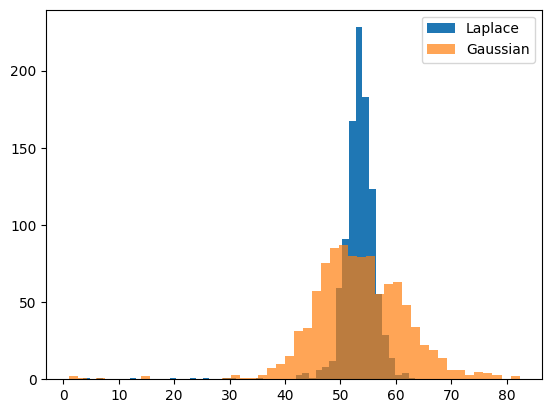

In [98]:
plt.hist(laplace_mean_grades_male, bins=50, label='Laplace')
plt.hist(gaussian_mean_grades_male, alpha=.7, bins=50, label='Gaussian')
plt.legend()

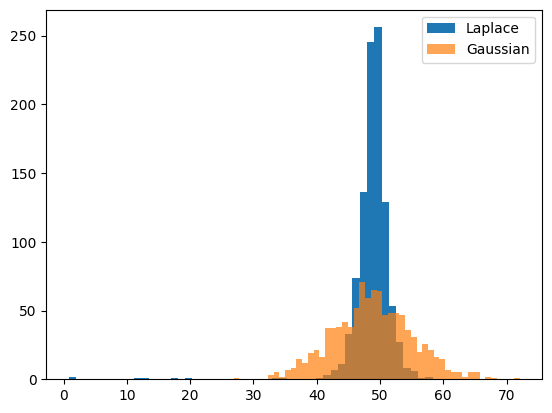

In [99]:
plt.hist(laplace_mean_grades_female, bins=50, label='Laplace')
plt.hist(gaussian_mean_grades_female, alpha=.7, bins=50, label='Gaussian')
plt.legend()

#### Errors

In [105]:
laplace_male_pct_error = np.mean([pct_error(mean_grade_male, x) for x in laplace_mean_grades_male])
gaussian_male_pct_error = np.mean([pct_error(mean_grade_male, x) for x in gaussian_mean_grades_male])

laplace_female_pct_error = np.mean([pct_error(mean_grade_female, x) for x in laplace_mean_grades_female])
gaussian_female_pct_error = np.mean([pct_error(mean_grade_female, x) for x in gaussian_mean_grades_female])

print("Average Percent Error Laplace Male: ", laplace_male_pct_error)
print("Average Percent Error Gaussian Male: ", gaussian_male_pct_error)

print("Average Percent Error Laplace Female: ", laplace_female_pct_error)
print("Average Percent Error Gaussian Female: ", gaussian_female_pct_error)

Average Percent Error Laplace Male:  4.396869505739331
Average Percent Error Gaussian Male:  11.928420811458535
Average Percent Error Laplace Female:  3.947878736301438
Average Percent Error Gaussian Female:  10.118756930462784
